In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import remove_outliers
import h5py




astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension
pad = n//8
npos= 36
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = z1c
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

# sample size after demagnification
ne = 4608+2*pad
show = True

flg = f'{n}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'
print(voxelsize)

4.570312499999999e-08


## Read data

In [3]:
data00 = np.zeros([1, npos, n, n], dtype='float32')
ref0 = np.zeros([1, npos, n, n], dtype='float32')
print(f'{path}/data_{0}_{flg}.tiff')
for k in range(npos):
    data00[:, k] = read_tiff(f'{path}/data_{k}_{flg}.tiff')[:1]
for k in range(npos):
    ref0[:, k] = read_tiff(f'{path}/ref_{k}_{flg}.tiff')[:]
code = np.load(f'{path}/code_{flg}.npy')
shifts_code = np.load(f'{path}/shifts_code_nfp_{flg}.npy')[:, :npos]


/data2/vnikitin/nfp_codes/data_0_2048_-0.0195.tiff


# Construct operators


In [4]:
def Lop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir
    return psi

def Sop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi


data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = Sop(arr1)
arr3 = STop(arr2)

arr4 = Lop(arr2)
arr5 = LTop(arr4)


print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')

(309580448-9.973982810974121j)==
(309580480-1.92062667853099e-11j)
(199966912-7.465576171875j)==
(199966896+0.00015021691797301173j)


#### Reconstruction with the CG (Carlsson) with Hessians

0) alpha=0.01431, err=2.57851e+06


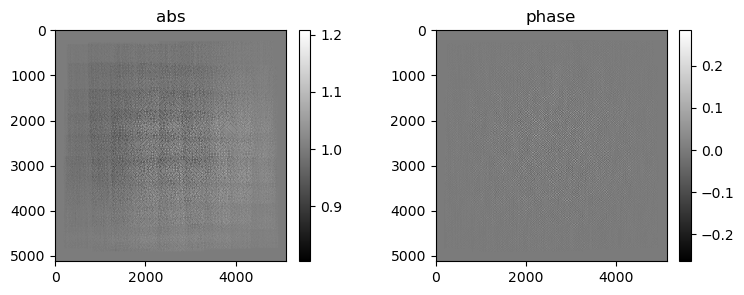

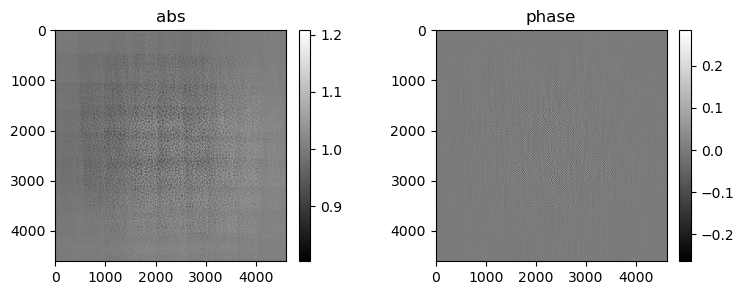

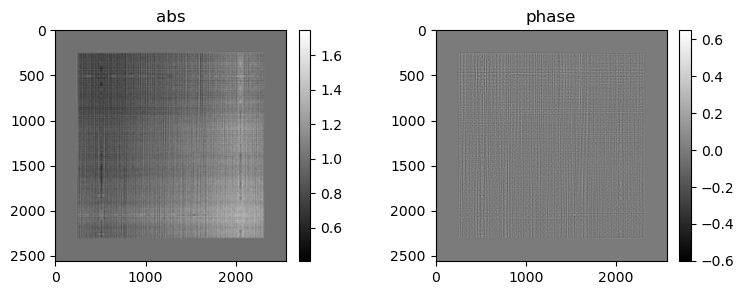

1) alpha=0.04224, err=1.31446e+06
2) alpha=0.01776, err=1.11051e+06
3) alpha=0.04448, err=9.23057e+05
4) alpha=0.02565, err=8.68276e+05
5) alpha=0.05869, err=7.90366e+05
6) alpha=0.05032, err=7.39397e+05
7) alpha=0.05306, err=6.64143e+05
8) alpha=0.02562, err=5.92818e+05
9) alpha=0.04452, err=4.91331e+05
10) alpha=0.03568, err=4.11497e+05
11) alpha=0.05624, err=3.27752e+05
12) alpha=0.02591, err=2.91931e+05
13) alpha=0.05657, err=2.44453e+05
14) alpha=0.03588, err=2.20018e+05
15) alpha=0.04246, err=1.87910e+05
16) alpha=0.03530, err=1.70301e+05


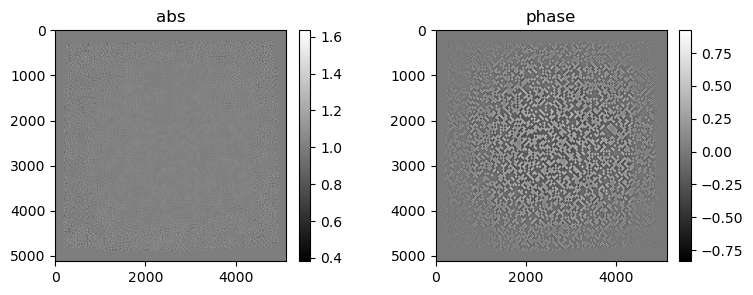

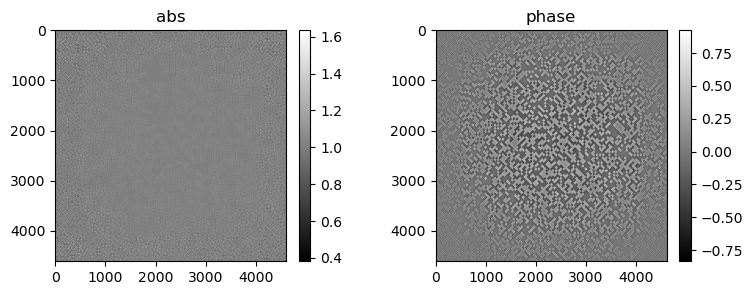

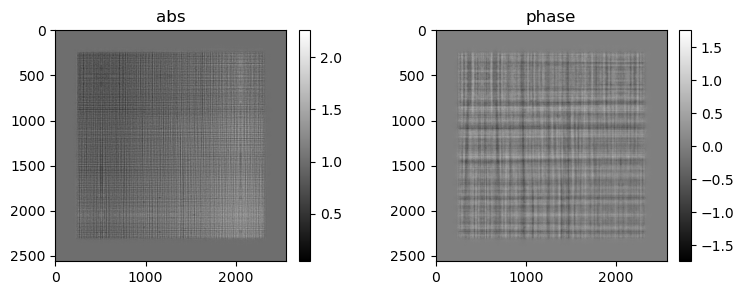

17) alpha=0.04226, err=1.45483e+05
18) alpha=0.04365, err=1.31002e+05
19) alpha=0.03749, err=1.15167e+05
20) alpha=0.04483, err=1.03010e+05
21) alpha=0.03390, err=9.06621e+04
22) alpha=0.04372, err=8.16830e+04
23) alpha=0.03801, err=7.23339e+04
24) alpha=0.03865, err=6.53646e+04
25) alpha=0.03700, err=5.83758e+04
26) alpha=0.03976, err=5.30252e+04
27) alpha=0.03808, err=4.79053e+04
28) alpha=0.03777, err=4.38147e+04
29) alpha=0.04059, err=3.99444e+04
30) alpha=0.03943, err=3.67422e+04
31) alpha=0.03708, err=3.39489e+04
32) alpha=0.03742, err=3.15088e+04


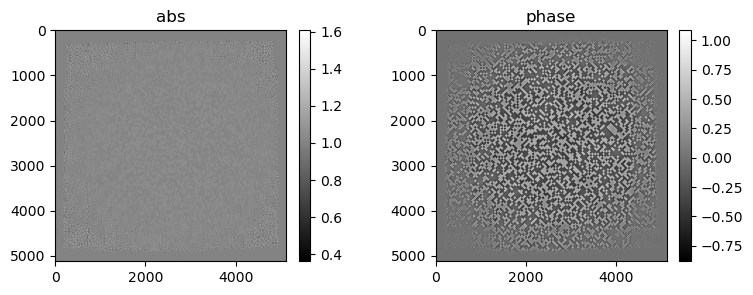

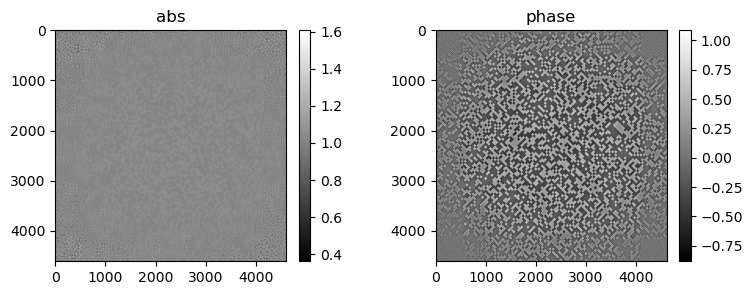

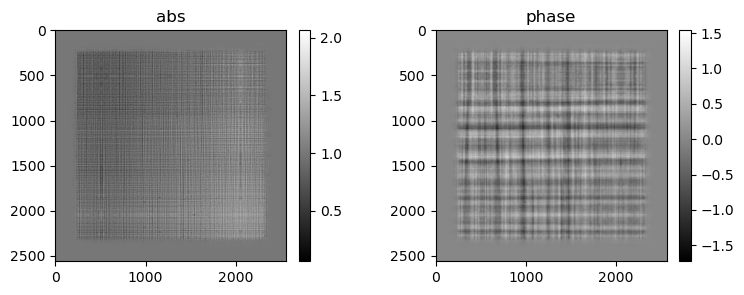

33) alpha=0.03867, err=2.92788e+04
34) alpha=0.04085, err=2.72328e+04
35) alpha=0.03832, err=2.54880e+04
36) alpha=0.03923, err=2.38741e+04
37) alpha=0.03817, err=2.24092e+04
38) alpha=0.04063, err=2.10371e+04
39) alpha=0.03910, err=1.97958e+04
40) alpha=0.04118, err=1.86340e+04
41) alpha=0.03850, err=1.75678e+04
42) alpha=0.03874, err=1.66124e+04
43) alpha=0.03860, err=1.56904e+04
44) alpha=0.04050, err=1.48299e+04
45) alpha=0.04186, err=1.40122e+04
46) alpha=0.03870, err=1.32959e+04
47) alpha=0.03856, err=1.26220e+04
48) alpha=0.03855, err=1.19815e+04


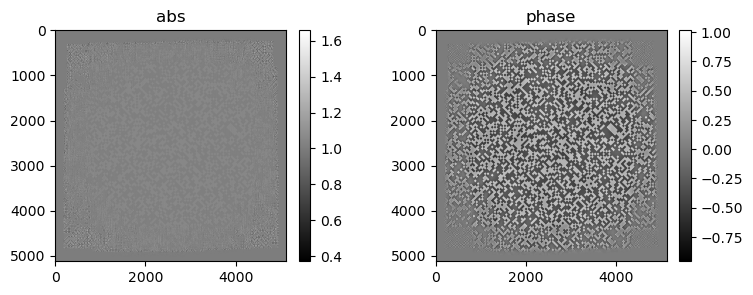

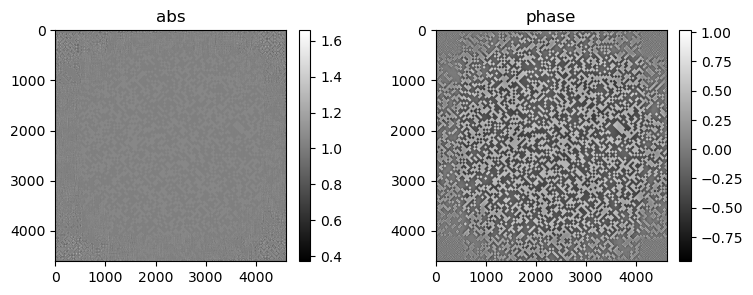

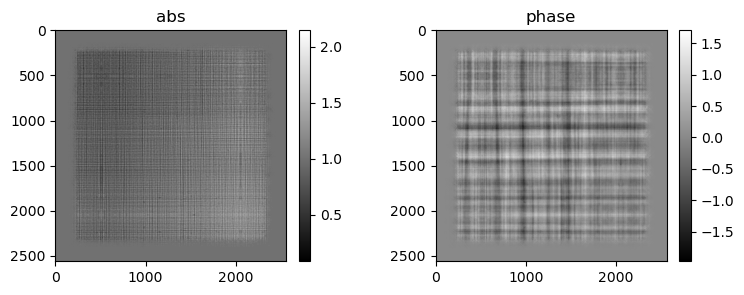

49) alpha=0.04031, err=1.13844e+04
50) alpha=0.04126, err=1.08085e+04
51) alpha=0.04068, err=1.02872e+04
52) alpha=0.04069, err=9.79085e+03
53) alpha=0.03708, err=9.35054e+03
54) alpha=0.03940, err=8.91904e+03
55) alpha=0.03835, err=8.51133e+03
56) alpha=0.04325, err=8.11302e+03
57) alpha=0.04110, err=7.74089e+03
58) alpha=0.03983, err=7.40676e+03
59) alpha=0.03887, err=7.08115e+03
60) alpha=0.03923, err=6.78139e+03
61) alpha=0.03989, err=6.48887e+03
62) alpha=0.03930, err=6.21751e+03
63) alpha=0.04048, err=5.95628e+03
64) alpha=0.03926, err=5.71146e+03


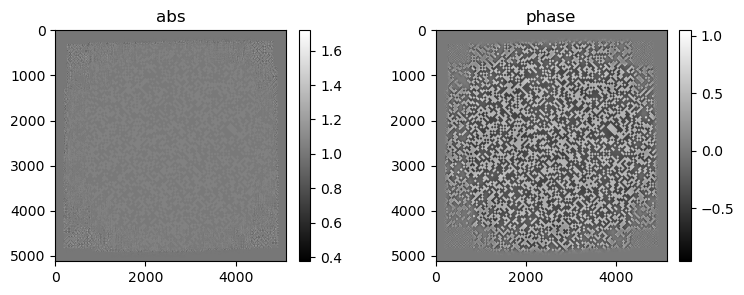

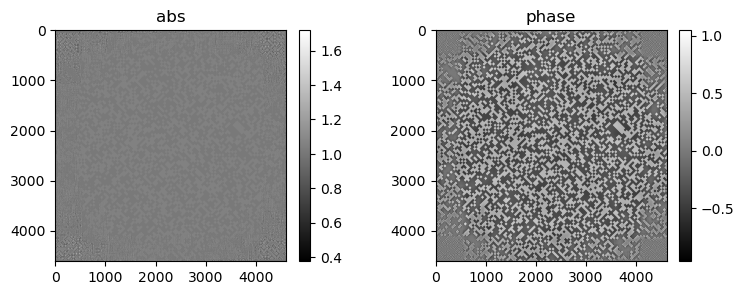

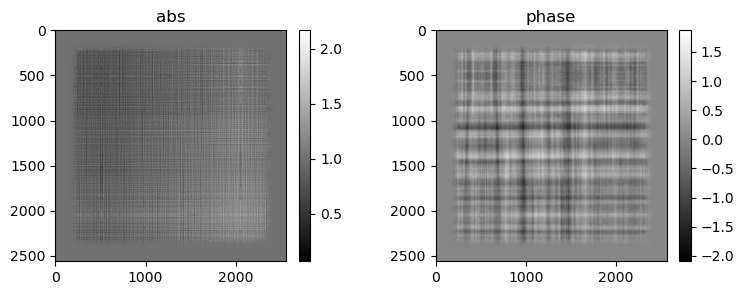

65) alpha=0.03974, err=5.48067e+03
66) alpha=0.03981, err=5.25761e+03
67) alpha=0.04027, err=5.04939e+03
68) alpha=0.04081, err=4.84800e+03
69) alpha=0.03843, err=4.66543e+03
70) alpha=0.03951, err=4.48783e+03
71) alpha=0.03930, err=4.31879e+03
72) alpha=0.04182, err=4.15602e+03
73) alpha=0.03944, err=4.00424e+03
74) alpha=0.03914, err=3.86346e+03
75) alpha=0.03873, err=3.72631e+03
76) alpha=0.03972, err=3.59699e+03
77) alpha=0.04101, err=3.46976e+03
78) alpha=0.04041, err=3.35127e+03
79) alpha=0.04136, err=3.23631e+03
80) alpha=0.03889, err=3.13061e+03


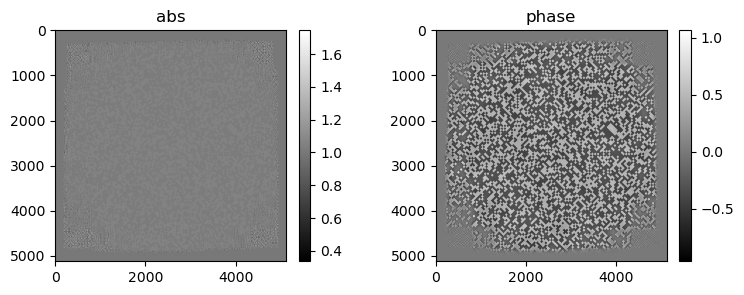

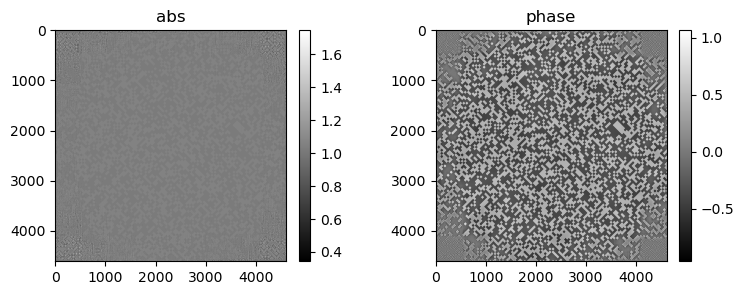

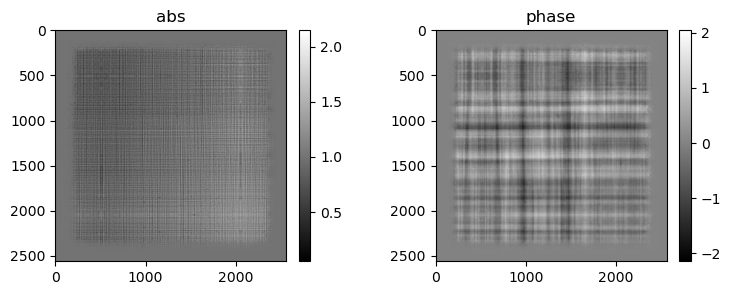

81) alpha=0.03856, err=3.02995e+03
82) alpha=0.03943, err=2.93094e+03
83) alpha=0.04055, err=2.83683e+03
84) alpha=0.04111, err=2.74548e+03
85) alpha=0.03904, err=2.66133e+03
86) alpha=0.03952, err=2.57975e+03
87) alpha=0.03912, err=2.50143e+03
88) alpha=0.04169, err=2.42511e+03
89) alpha=0.04052, err=2.35246e+03
90) alpha=0.04016, err=2.28472e+03
91) alpha=0.03847, err=2.21979e+03
92) alpha=0.03861, err=2.15817e+03
93) alpha=0.04018, err=2.09700e+03
94) alpha=0.04106, err=2.03828e+03
95) alpha=0.04189, err=1.98159e+03
96) alpha=0.03943, err=1.92885e+03


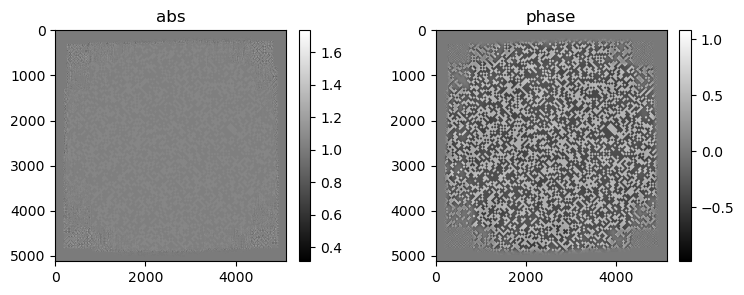

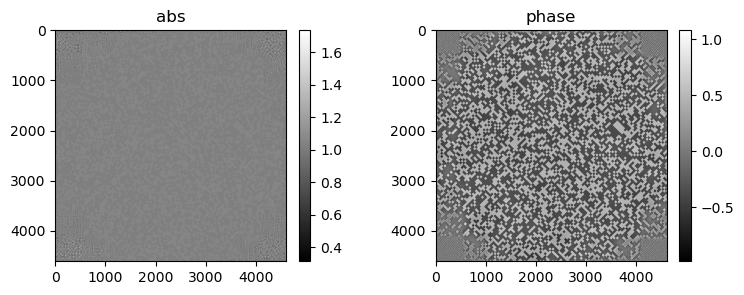

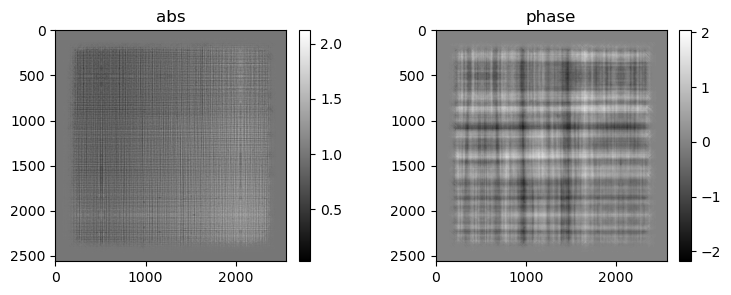

97) alpha=0.03898, err=1.87845e+03
98) alpha=0.03891, err=1.82937e+03
99) alpha=0.04013, err=1.78177e+03
100) alpha=0.04176, err=1.73465e+03
101) alpha=0.04073, err=1.69048e+03
102) alpha=0.03988, err=1.64813e+03
103) alpha=0.03801, err=1.60803e+03
104) alpha=0.04011, err=1.56811e+03
105) alpha=0.04006, err=1.52947e+03
106) alpha=0.04122, err=1.49190e+03
107) alpha=0.04050, err=1.45563e+03
108) alpha=0.03991, err=1.42114e+03
109) alpha=0.04002, err=1.38716e+03
110) alpha=0.03995, err=1.35466e+03
111) alpha=0.04011, err=1.32275e+03
112) alpha=0.03963, err=1.29218e+03


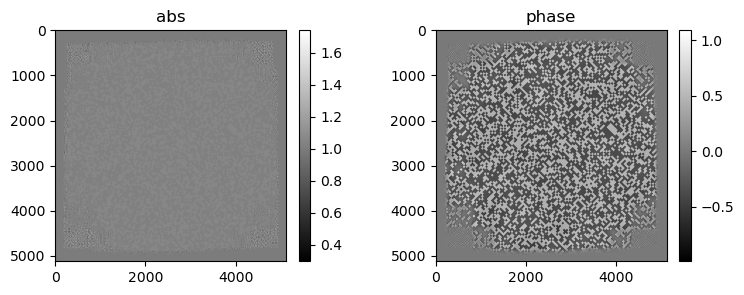

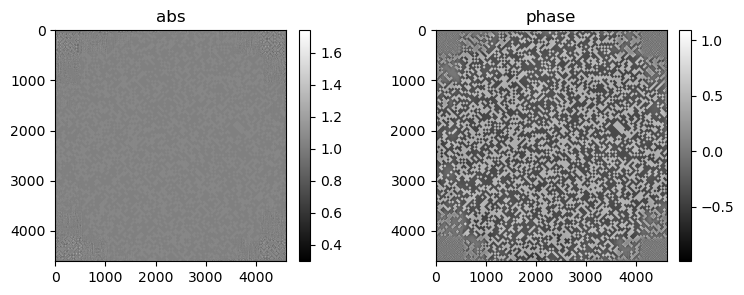

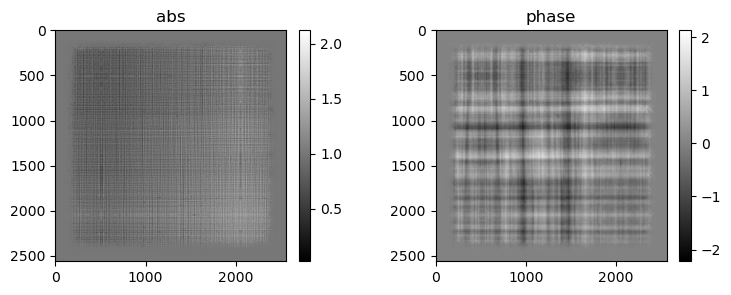

113) alpha=0.03953, err=1.26244e+03
114) alpha=0.03951, err=1.23333e+03
115) alpha=0.04107, err=1.20470e+03
116) alpha=0.04144, err=1.17657e+03
117) alpha=0.04120, err=1.14963e+03
118) alpha=0.03951, err=1.12391e+03
119) alpha=0.03824, err=1.09914e+03
120) alpha=0.04021, err=1.07434e+03
121) alpha=0.04066, err=1.05006e+03
122) alpha=0.04152, err=1.02637e+03
123) alpha=0.04046, err=1.00349e+03
124) alpha=0.03951, err=9.81612e+02
125) alpha=0.03883, err=9.60240e+02
126) alpha=0.03992, err=9.39078e+02
127) alpha=0.04148, err=9.18081e+02
128) alpha=0.04153, err=8.97662e+02


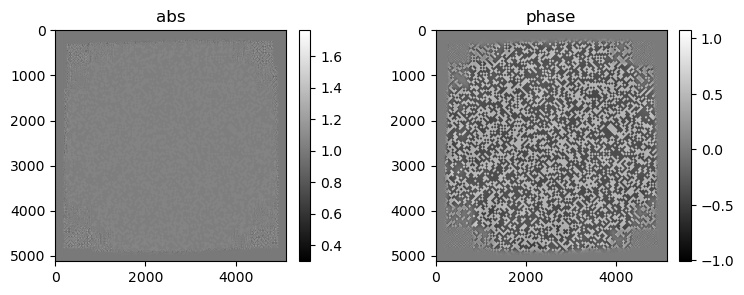

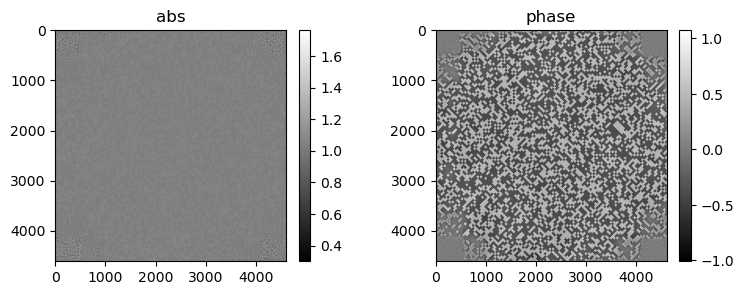

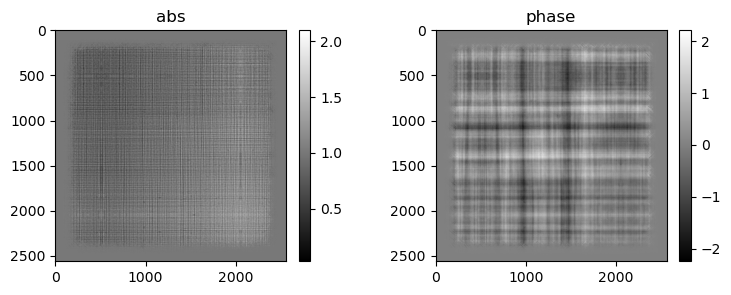

129) alpha=0.04062, err=8.78075e+02
130) alpha=0.03890, err=8.59354e+02
131) alpha=0.03873, err=8.40953e+02
132) alpha=0.04116, err=8.22487e+02
133) alpha=0.04071, err=8.04639e+02
134) alpha=0.04062, err=7.87311e+02
135) alpha=0.03940, err=7.70565e+02
136) alpha=0.03968, err=7.54175e+02
137) alpha=0.04018, err=7.37988e+02
138) alpha=0.04125, err=7.22072e+02
139) alpha=0.04108, err=7.06556e+02
140) alpha=0.04020, err=6.91748e+02
141) alpha=0.03854, err=6.77440e+02
142) alpha=0.03928, err=6.63413e+02
143) alpha=0.04030, err=6.49433e+02
144) alpha=0.04180, err=6.35701e+02


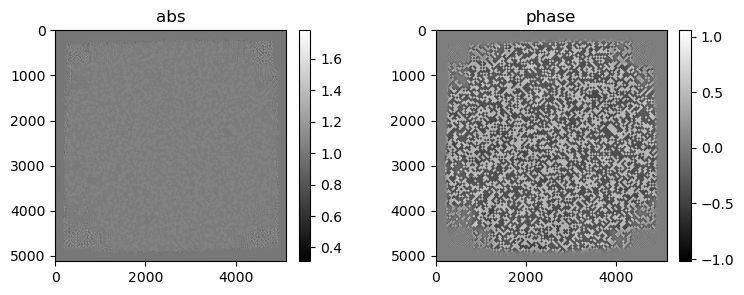

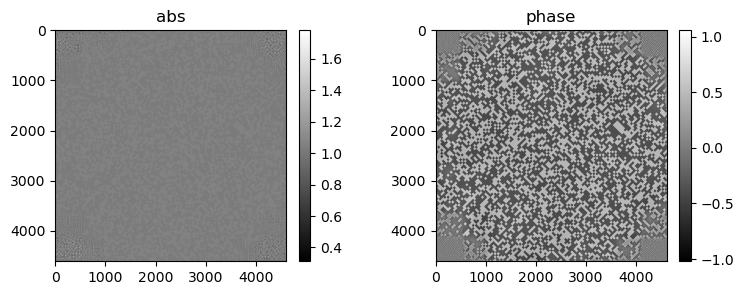

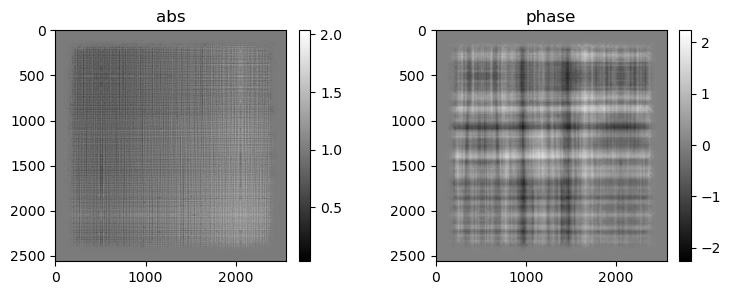

145) alpha=0.04121, err=6.22458e+02
146) alpha=0.03948, err=6.09856e+02
147) alpha=0.03917, err=5.97583e+02
148) alpha=0.03990, err=5.85440e+02
149) alpha=0.04044, err=5.73629e+02
150) alpha=0.04088, err=5.62035e+02
151) alpha=0.03991, err=5.50930e+02
152) alpha=0.03996, err=5.40118e+02
153) alpha=0.03916, err=5.29616e+02
154) alpha=0.04066, err=5.19279e+02
155) alpha=0.04016, err=5.09205e+02
156) alpha=0.04029, err=4.99511e+02
157) alpha=0.03953, err=4.90070e+02
158) alpha=0.03968, err=4.80894e+02
159) alpha=0.04124, err=4.71746e+02
160) alpha=0.04095, err=4.62930e+02


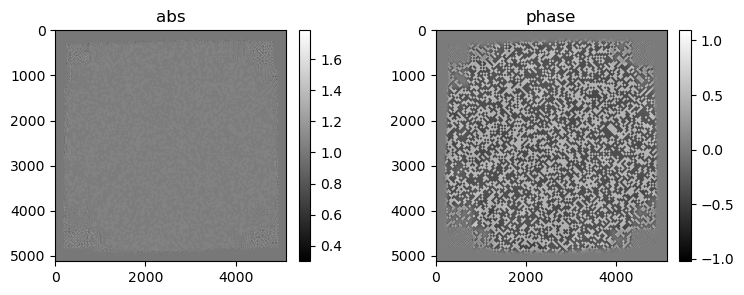

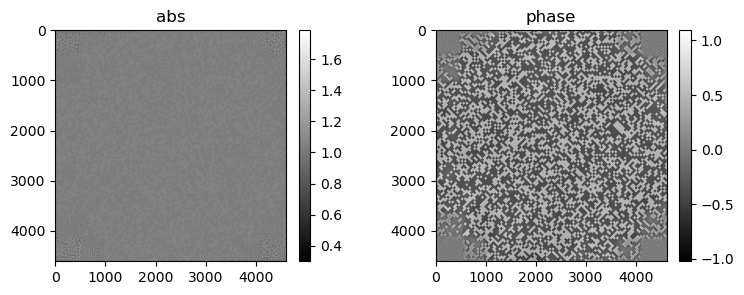

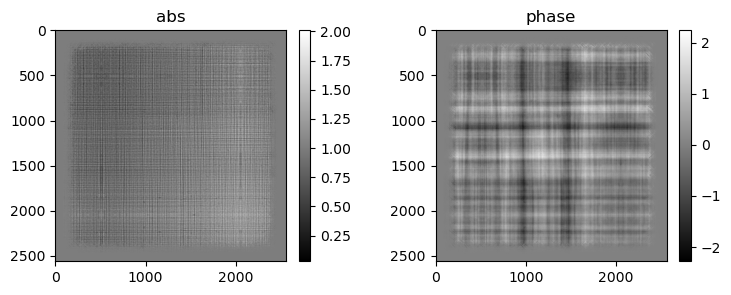

161) alpha=0.04066, err=4.54390e+02
162) alpha=0.03867, err=4.46281e+02
163) alpha=0.03857, err=4.38327e+02
164) alpha=0.04022, err=4.30365e+02
165) alpha=0.04156, err=4.22533e+02
166) alpha=0.04183, err=4.14894e+02
167) alpha=0.04115, err=4.07537e+02
168) alpha=0.03969, err=4.00538e+02
169) alpha=0.03826, err=3.93786e+02
170) alpha=0.03940, err=3.87104e+02
171) alpha=0.04083, err=3.80470e+02
172) alpha=0.04158, err=3.74001e+02
173) alpha=0.04068, err=3.67779e+02
174) alpha=0.03901, err=3.61847e+02
175) alpha=0.03900, err=3.56004e+02
176) alpha=0.04078, err=3.50189e+02


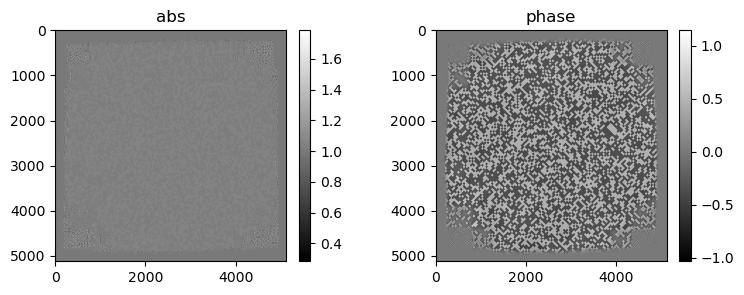

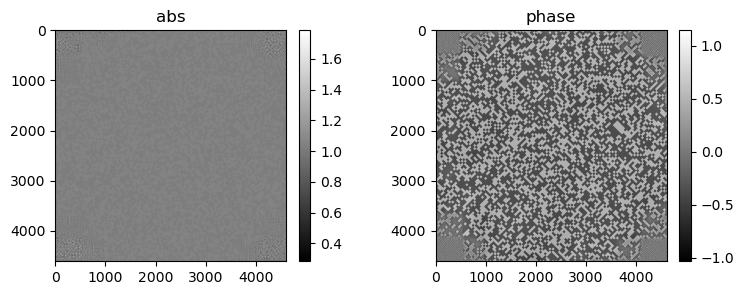

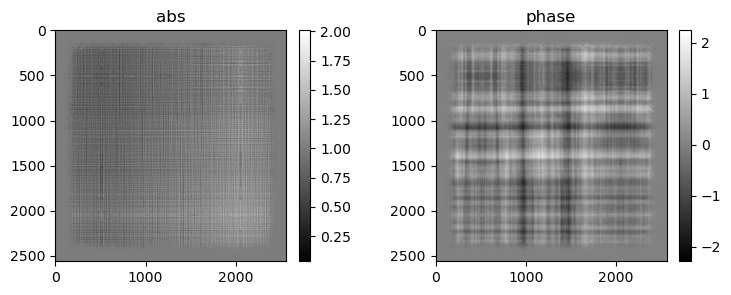

177) alpha=0.04104, err=3.44513e+02
178) alpha=0.04104, err=3.39010e+02
179) alpha=0.03980, err=3.33716e+02
180) alpha=0.03935, err=3.28588e+02
181) alpha=0.03931, err=3.23554e+02
182) alpha=0.04051, err=3.18582e+02
183) alpha=0.04074, err=3.13719e+02
184) alpha=0.04031, err=3.09014e+02
185) alpha=0.03958, err=3.04439e+02
186) alpha=0.03969, err=2.99945e+02
187) alpha=0.04085, err=2.95472e+02
188) alpha=0.04148, err=2.91081e+02
189) alpha=0.04064, err=2.86845e+02
190) alpha=0.03927, err=2.82770e+02
191) alpha=0.03877, err=2.78781e+02
192) alpha=0.04008, err=2.74799e+02


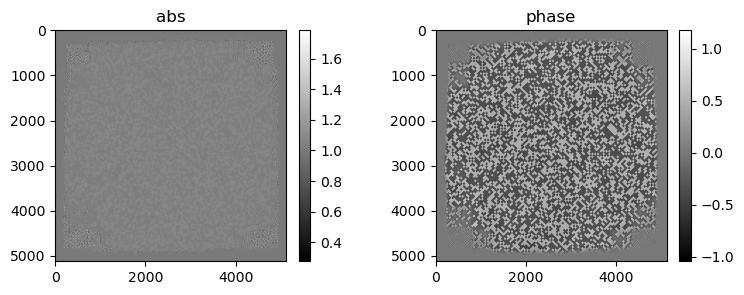

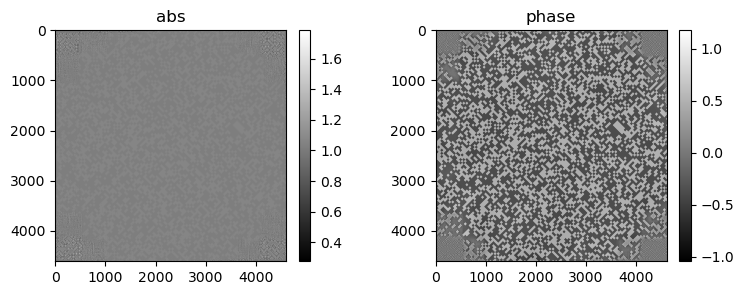

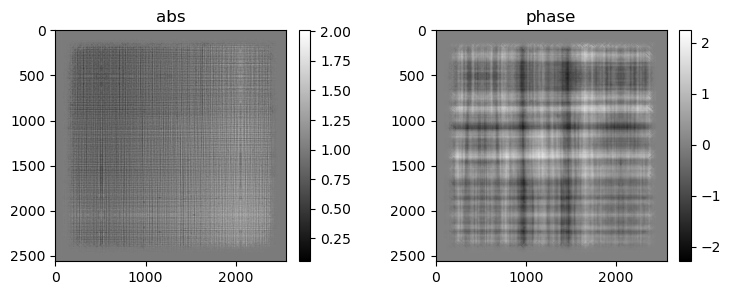

193) alpha=0.04100, err=2.70865e+02
194) alpha=0.04115, err=2.67020e+02
195) alpha=0.04059, err=2.63276e+02
196) alpha=0.03971, err=2.59650e+02
197) alpha=0.03999, err=2.56060e+02
198) alpha=0.04040, err=2.52528e+02
199) alpha=0.04070, err=2.49055e+02
200) alpha=0.03997, err=2.45687e+02
201) alpha=0.03924, err=2.42416e+02
202) alpha=0.03966, err=2.39163e+02
203) alpha=0.04084, err=2.35944e+02
204) alpha=0.04166, err=2.32752e+02
205) alpha=0.04083, err=2.29676e+02
206) alpha=0.03986, err=2.26698e+02
207) alpha=0.03861, err=2.23800e+02
208) alpha=0.04009, err=2.20907e+02


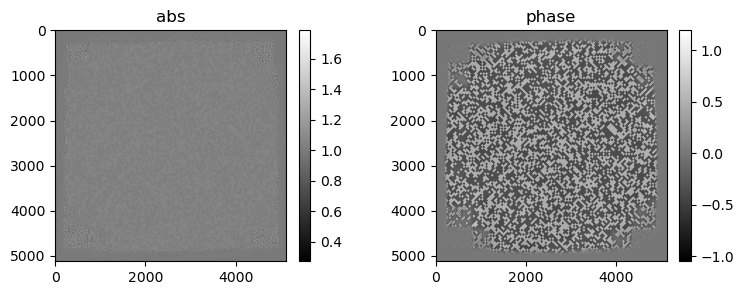

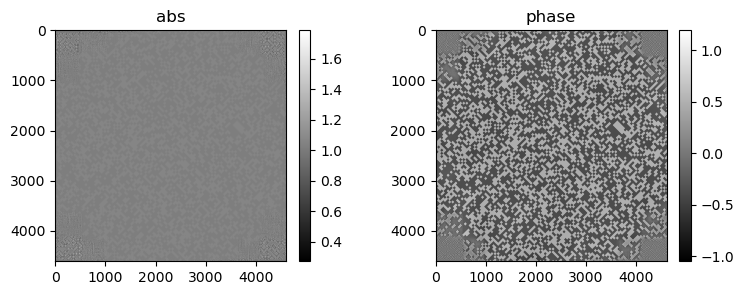

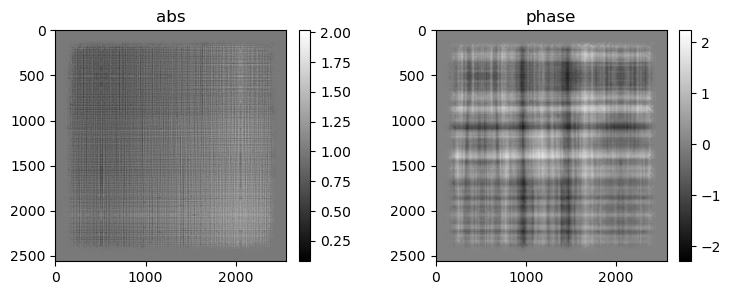

209) alpha=0.04096, err=2.18022e+02
210) alpha=0.04180, err=2.15198e+02
211) alpha=0.04075, err=2.12453e+02
212) alpha=0.03916, err=2.09835e+02
213) alpha=0.03864, err=2.07248e+02
214) alpha=0.03994, err=2.04665e+02
215) alpha=0.04175, err=2.02078e+02
216) alpha=0.04205, err=1.99537e+02
217) alpha=0.04140, err=1.97075e+02
218) alpha=0.03941, err=1.94712e+02
219) alpha=0.03863, err=1.92398e+02
220) alpha=0.03992, err=1.90070e+02
221) alpha=0.04101, err=1.87756e+02
222) alpha=0.04120, err=1.85482e+02
223) alpha=0.04044, err=1.83266e+02
224) alpha=0.03981, err=1.81099e+02


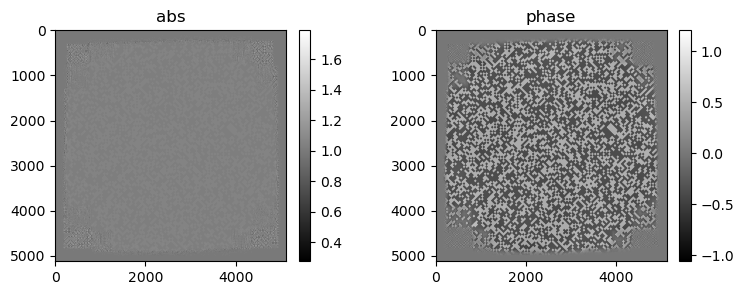

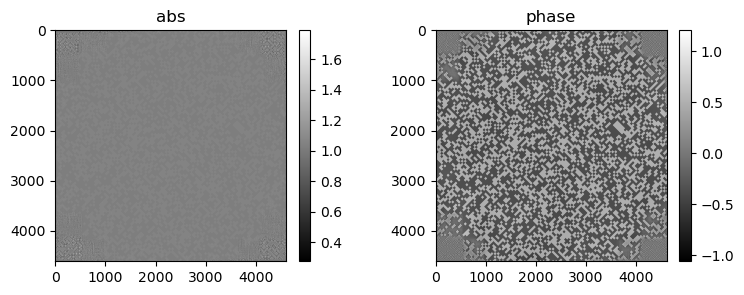

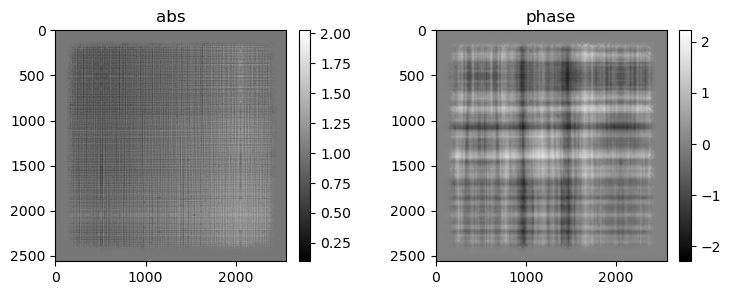

225) alpha=0.04010, err=1.78952e+02
226) alpha=0.04061, err=1.76825e+02
227) alpha=0.04076, err=1.74733e+02
228) alpha=0.04035, err=1.72687e+02
229) alpha=0.03947, err=1.70692e+02
230) alpha=0.03976, err=1.68714e+02
231) alpha=0.04060, err=1.66737e+02
232) alpha=0.04132, err=1.64786e+02
233) alpha=0.04067, err=1.62878e+02
234) alpha=0.03935, err=1.61035e+02
235) alpha=0.03954, err=1.59198e+02
236) alpha=0.04044, err=1.57368e+02
237) alpha=0.04170, err=1.55544e+02
238) alpha=0.04108, err=1.53766e+02
239) alpha=0.04016, err=1.52040e+02
240) alpha=0.03909, err=1.50353e+02


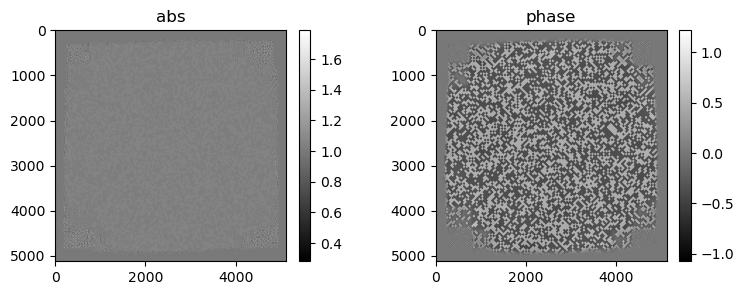

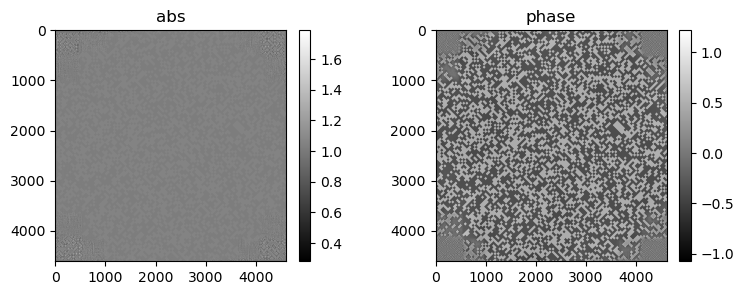

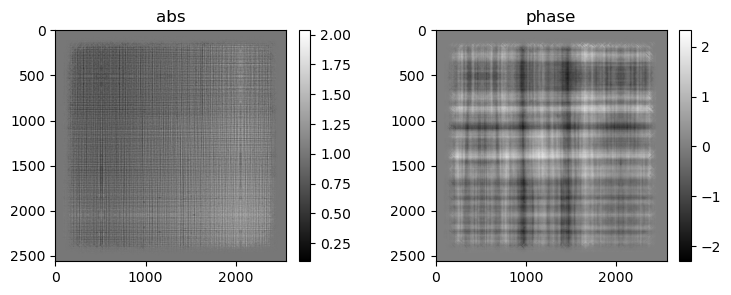

241) alpha=0.03949, err=1.48679e+02
242) alpha=0.04063, err=1.47003e+02
243) alpha=0.04131, err=1.45343e+02
244) alpha=0.04080, err=1.43725e+02
245) alpha=0.03994, err=1.42143e+02
246) alpha=0.03950, err=1.40590e+02
247) alpha=0.04083, err=1.39027e+02
248) alpha=0.04111, err=1.37489e+02
249) alpha=0.04109, err=1.35979e+02
250) alpha=0.03933, err=1.34522e+02
251) alpha=0.03909, err=1.33086e+02
252) alpha=0.03988, err=1.31645e+02
253) alpha=0.04146, err=1.30204e+02
254) alpha=0.04196, err=1.28772e+02
255) alpha=0.04136, err=1.27380e+02
256) alpha=0.03968, err=1.26036e+02


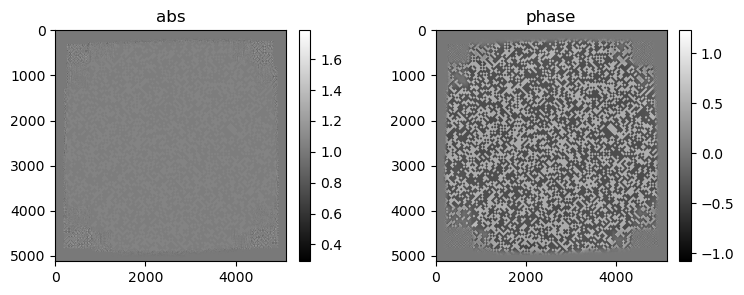

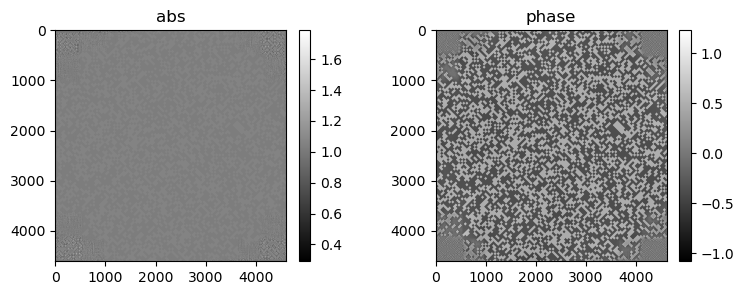

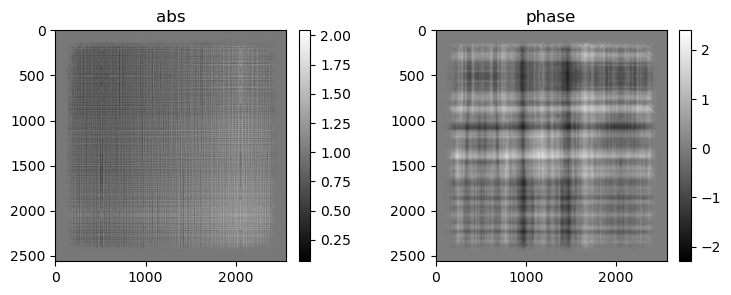

In [5]:
def redot(a,b):
    return cp.sum(a.real*b.real+a.imag*b.imag)

def hessian2(Lpsi,Lpsi1,Lpsi2,data):
    l0 = Lpsi/cp.abs(Lpsi)
    d0 = data/cp.abs(Lpsi)
    v1 = redot(1-d0,cp.real(Lpsi1*cp.conj(Lpsi2)))
    v2 = redot(d0,cp.real(cp.conj(l0)*Lpsi1)*cp.real(cp.conj(l0)*Lpsi2))
    return 2*(v1+v2)

def minf(fpsi,data):
    f = np.linalg.norm(np.abs(fpsi)-data)**2
    return f

def cg_holo(data, init_psi,init_prb,  pars):
    
    data = np.sqrt(data)
    
    psi = init_psi.copy()
    prb = init_prb.copy()

    erra = np.zeros(pars['niter'])
    alphaa = np.zeros(pars['niter'])
    
    for i in range(pars['niter']):                                        
        
        Lpsi = Lop(Sop(psi)*prb)                
        gradx = 2*LTop(Lpsi-data*(Lpsi/cp.abs(Lpsi)))  
        
        gradpsi = STop(gradx*cp.conj(prb))                     
        gradprb = cp.sum(gradx*cp.conj(Sop(psi)),axis=1)
        
        if i==0:
            etapsi = -gradpsi
            etaprb = -gradprb
        else:
            Lpsi = Lop(Sop(psi)*prb)            
            Lksi = Lop(Sop(gradpsi)*prb+Sop(psi)*gradprb)   
            Leta = Lop(Sop(etapsi)*prb+Sop(psi)*etaprb)     
            # top
            top = hessian2(Lpsi,Lksi,Leta,data)
            top += redot(gradx,Sop(gradpsi)*etaprb+Sop(etapsi)*gradprb)
            # bottom
            bottom = hessian2(Lpsi,Leta,Leta,data)
            bottom += 2*redot(gradx,Sop(etapsi)*etaprb)

            beta = top/bottom
            
            etapsi = -gradpsi + beta*etapsi
            etaprb = -gradprb + beta*etaprb

        #top
        top = -redot(gradpsi,etapsi)-redot(gradprb,etaprb)
        # bottom
        Lpsi = Lop(Sop(psi)*prb)
        Leta = Lop(Sop(etapsi)*prb+Sop(psi)*etaprb)
        
        bottom = hessian2(Lpsi,Leta,Leta,data)
        bottom += 2*redot(gradx,Sop(etapsi)*etaprb)
        
        alpha = top/bottom

        psi += alpha*etapsi
        prb += alpha*etaprb

        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi)*prb)
            err = minf(fpsi,data)
            erra[i] = err
            alphaa[i] = alpha
            print(f'{i}) {alpha=:.5f}, {err=:1.5e}')

        if i % pars['vis_step'] == 0 and pars['vis_step']>0 :
            mshow_polar(psi[0],show)
            mshow_polar(psi[0,pad:-pad,pad:-pad],show)
            mshow_polar(prb[0],show)
            np.save(f'{path}/rec_code_{flg}_{i:03}',psi.get())
            np.save(f'{path}/rec_prb_{flg}_{i:03}',prb.get())

    return psi,prb,erra,alphaa

# fully on gpu
rec_psi = cp.ones([1,ne,ne],dtype='complex64')#recMultiPaganin.copy()*0+1
data = cp.array(data00.copy())

rec_prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
pars = {'niter':257, 'err_step': 1, 'vis_step': 16}
rec_psi,rec_prb,erra,alphaa = cg_holo(data,rec_psi,rec_prb, pars)

In [6]:
np.save(f'{path}/rec_code_{flg}',rec_psi.get())
np.save(f'{path}/rec_prb_{flg}',rec_prb.get())
np.save(f'{path}/erra_{flg}',erra)
np.save(f'{path}/alphaa_{flg}',alphaa)